#**Importing Data and Needed Libraries**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Conv1D, LSTM,MaxPooling1D, AveragePooling1D, Concatenate, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import datetime
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Concatenate, Input
from keras.utils.vis_utils import plot_model
from keras import regularizers


df=pd.read_csv('building-electrical-energy-daily-use-ubcv-2019-2021.csv')
columns = df.columns;

#**Data Preprocessing**

##**Filling NaN values by the mean of the column relative to it**

In [2]:
for i in range(1,len(df. columns)-1):
    df[columns[i]] = df[columns[i]].fillna(df[columns[i]].mean());

##**Summing the Energy Consumption of all buildings for each day**

In [3]:
df["Total Energy Consumption"] = df[columns[1:]].sum(axis = 1);

##**Drop the Energy Consumption of individual buildings**

In [4]:
for i in range(1,len(columns)):
    df = df.drop(columns[i], axis = 1)

##**Transfer Date column into Datatime type**

In [5]:
for i in range(0,len(df["Date"])):
    df.loc[ i,'Date']= datetime.strptime(df["Date"].loc[i], '%m/%d/%Y');

##**Extracting Features from Date column**

In [6]:
df["Date"] = pd.to_datetime(df["Date"])

#Date features
df["Day"] = df["Date"].dt.dayofweek
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year
df["Q"] = df["Date"].dt.quarter
df["Dayofyear"] = df["Date"].dt.dayofyear
df["Dayofmonth"] = df["Date"].dt.day
df["Weekofyear"] = df["Date"].dt.isocalendar().week

In [7]:
df["Holiday"] = 0;# Column that includes where a specific day is a Holdiay or not based on the Holiday Days in the United states
for i in range(0,len(df["Dayofmonth"])):
    if(df['Dayofmonth'][i] == 1 and df["Month"][i] == 1):
        df.loc[ i, 'Holiday']  = 1
        
    elif(df['Dayofmonth'][i] == 21 and df["Month"][i] == 2):
        df.loc[ i, 'Holiday']  = 1
        
    elif(df['Dayofmonth'][i] == 15 and df["Month"][i] == 4):
        df.loc[ i, 'Holiday']  = 1
        
    elif(df['Dayofmonth'][i] == 18 and df["Month"][i] == 4):
        df.loc[ i, 'Holiday']  = 1
        
    elif(df['Dayofmonth'][i] == 23 and df["Month"][i] == 5):
        df.loc[ i, 'Holiday']  = 1
        
    elif(df['Dayofmonth'][i] == 1 and df["Month"][i] == 7):
        df.loc[ i, 'Holiday']  = 1
        
    elif(df['Dayofmonth'][i] == 1 and df["Month"][i] == 8):
        df.loc[ i, 'Holiday']  = 1
        
    elif(df['Dayofmonth'][i] == 5 and df["Month"][i] == 9):
        df.loc[ i, 'Holiday']  = 1
        
    elif(df['Dayofmonth'][i] == 10 and df["Month"][i] == 10):
        df.loc[ i, 'Holiday']  = 1
        
    elif(df['Dayofmonth'][i] == 25 and df["Month"][i] == 12):
        df.loc[ i, 'Holiday']  = 1
        
    elif(df['Dayofmonth'][i] == 26 and df["Month"][i] == 12):
        df.loc[ i, 'Holiday']  = 1
        
        
df.index = df["Date"]
df = df.drop(["Date"],axis=1)


##**Normalize the data**

In [8]:
columns=["Total Energy Consumption","Day","Month","Q","Dayofmonth","Weekofyear"]
std = df["Total Energy Consumption"].std()
mean = df["Total Energy Consumption"].mean()
df[columns] = (df[columns]-df[columns].mean())/(df[columns].std())

##**Split the data into training and testing**

In [9]:
df['Total Energy Consumption'] = df['Total Energy Consumption'].astype(np.float32)
df_train = df[df['Year']<2021]
df_test = df[df['Year']>=2021]

##**Identify the features that should be used**

In [10]:
features=["Total Energy Consumption","Day","Weekofyear","Holiday"]#adter testing these features seem to be the most iffective

##**Transfer DataFrame Elements into Arrays**

In [11]:
df = df.astype('float32')
power_train = df_train[features].to_numpy()
power_test = df_test[features].to_numpy()
print("Training set has {} observations.".format(len(power_train)))
print("Test set has {} observations.".format(len(power_test)))

Training set has 551 observations.
Test set has 181 observations.


##**Fix the issue with values: convert booleans to floats**

In [12]:
power_train = np.array(power_train)
power_test = np.asarray(power_test)

##**Create 7 days input and output sequences**

In [13]:
def supervised_setup(data,column):
  X,y = [], []
  input_start = 0
  n_input = 7
  n_out = 7

  for i in range(len(data)):
    input_end = input_start + n_input
    output_end = input_end + n_out

    if output_end <= len(data):# Each day in the vector has data about the energy consumption at that date, the Day at that Date, the week of the year at that Date, whether the day 7 days after is a Holiday
      x_input = data[input_start:input_end, column:];

      for j in range(0,7):
        x_input[j][-1] = data[input_start + 7:input_end + 7, -1][j]#Is the day 7 days later a Holiday?
      X.append(x_input);

      y.append(data[input_end:output_end,column].reshape((n_out,1)))
    input_start += 1
  return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

##**Obtain the sequences**

In [14]:
X_train, y_train = supervised_setup(power_train, 0)
X_test, y_test = supervised_setup(power_test, 0)

##**Splitting the previous Traing set into a new training set and a validation set**

In [15]:
val = round(0.8*X_train.shape[0])
X_train,X_val,y_train,y_val = X_train[0:val],X_train[val+1 : -1],y_train[0:val],y_train[val + 1 : -1]

##**Spliting Static and temporal inputs**

In [16]:
n_inputs, n_channels, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
X_ts_train = X_train[:,:,0]
X_ft_train = X_train[:,:,1:]
X_ts_val = X_val[:,:,0]
X_ft_val = X_val[:,:,1:]

#**TCN Model**

In [17]:
epochs = 300;
time_series = Input(shape=(n_inputs, 1))
other_feat = Input(shape=(n_inputs, n_channels-1))

conv1 = Conv1D(filters = 3, kernel_size = 2, padding = 'causal', dilation_rate = 5) (time_series)
conv2 = Conv1D(filters = 3, kernel_size = 2, padding = 'same', dilation_rate = 5) (conv1)
conv3 = Conv1D(filters = 3, kernel_size = 2, padding = 'same', dilation_rate = 5) (conv2)
pool = MaxPooling1D(pool_size = 5, strides = 4, padding = 'same') (conv3)
flat_ts = Flatten() (pool)
flat_ft = Flatten() (other_feat)

merged = Concatenate(axis = 1) ([flat_ts, flat_ft])
dense_network = Dense(100, activation = 'linear') (merged)
dense_network = Dense(50, activation = 'linear') (dense_network)
dense_network = Dense(25, activation = 'linear') (dense_network)
output_ts = Dense(7, activation = 'linear') (dense_network)

TCN_funct = Model(inputs = [time_series, other_feat], outputs = output_ts)

TCN_funct.compile(optimizer = 'adam', loss = "mse")

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience= 100, verbose=2, mode='min')
TCN_history = TCN_funct.fit(x = [X_ts_train, X_ft_train], y = y_train, validation_data=[[X_ts_val,X_ft_val], y_val], epochs = epochs, batch_size = 10,callbacks=[monitor]) 

Epoch 1/300
43/43 [==============================] - 2s 12ms/step - loss: 0.8617 - val_loss: 0.2841
Epoch 2/300
43/43 [==============================] - 0s 4ms/step - loss: 0.3248 - val_loss: 0.1809
Epoch 3/300
43/43 [==============================] - 0s 4ms/step - loss: 0.2883 - val_loss: 0.1746
Epoch 4/300
43/43 [==============================] - 0s 4ms/step - loss: 0.2711 - val_loss: 0.1587
Epoch 5/300
43/43 [==============================] - 0s 4ms/step - loss: 0.2637 - val_loss: 0.1441
Epoch 6/300
43/43 [==============================] - 0s 4ms/step - loss: 0.2643 - val_loss: 0.1414
Epoch 7/300
43/43 [==============================] - 0s 4ms/step - loss: 0.2566 - val_loss: 0.1637
Epoch 8/300
43/43 [==============================] - 0s 4ms/step - loss: 0.2598 - val_loss: 0.1505
Epoch 9/300
43/43 [==============================] - 0s 4ms/step - loss: 0.2543 - val_loss: 0.1619
Epoch 10/300
43/43 [==============================] - 0s 4ms/step - loss: 0.2531 - val_loss: 0.1452
Epoch 11

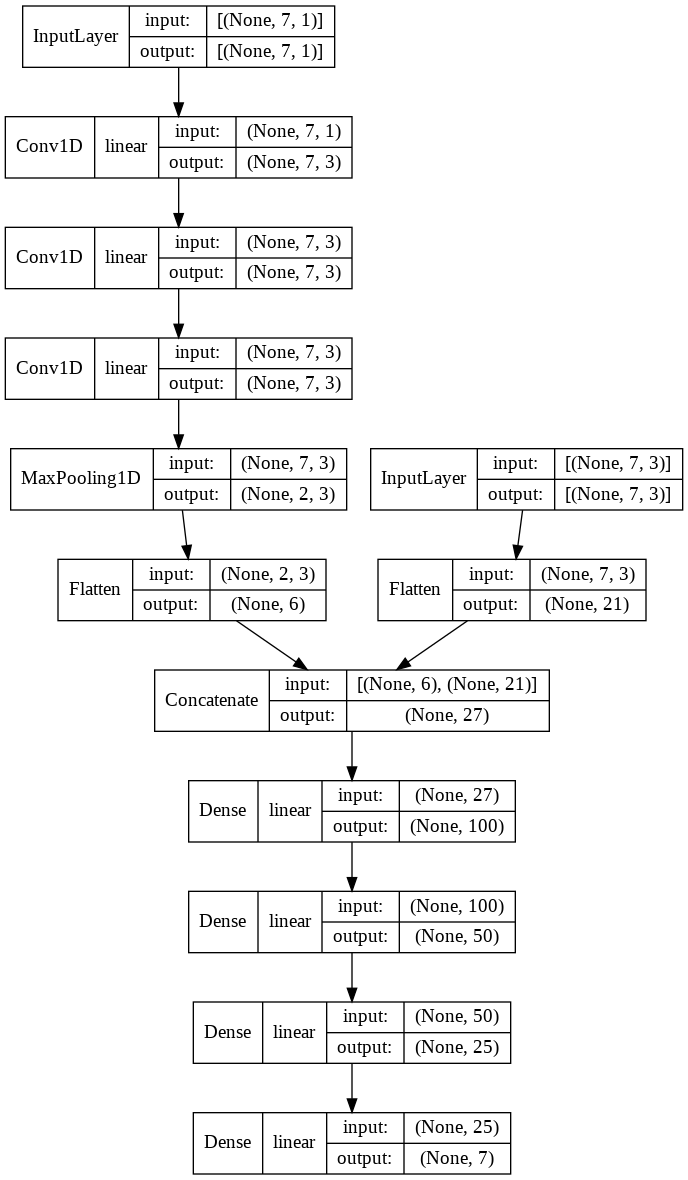

In [18]:
plot_model(TCN_funct, to_file='functional TCN model.png', show_shapes=True, show_dtype=False, show_layer_names=False, show_layer_activations=True)

##**TCN Model evalution on training and validation set**

14/14 [==============================] - 0s 2ms/step


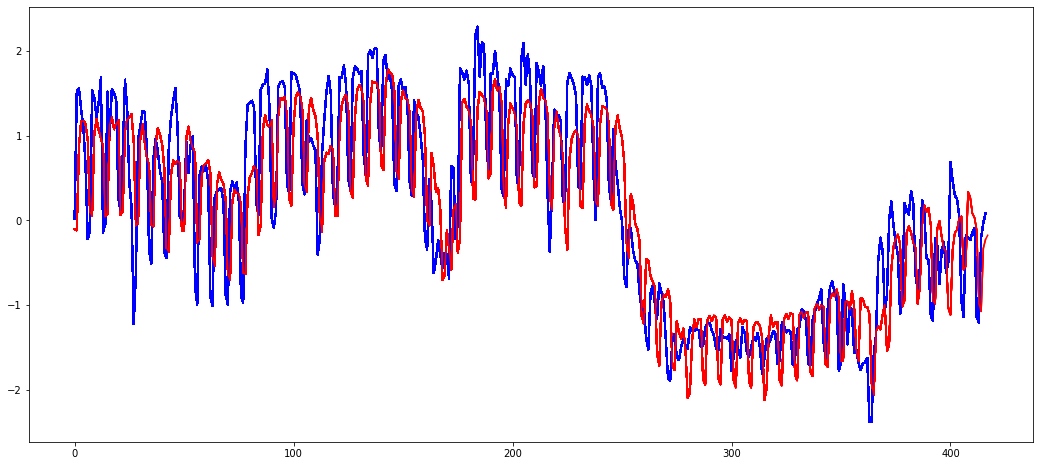

In [19]:
# cell that plots averaged predictions
y_predict_train= TCN_funct.predict([X_ts_train, X_ft_train])
y_tren= y_train[7:-6,0,0]
plotted_days=y_train.shape[0]-6*2
y_pred=[]
for d in range(0,plotted_days):
  prediction = 0
  for i in [0,1,2,3,4,5,6]:
    prediction = prediction + y_predict_train[d+i,6-i]
  prediction = prediction/7
  y_pred.append(prediction)
  plt.figure(num=1, figsize=[18,8])
  plt.plot(y_tren,color="blue")
  plt.plot(y_pred,color="red")

### Defined function used to measure multiple evaluation metrics

In [20]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)); mse = mean_squared_error(actual,forecast)
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax, 'mse':mse})

##**First Day prediction evaluation**

4/4 [==============================] - 0s 3ms/step
{'mape': 0.024961516, 'me': 636.7093, 'mae': 11902.579, 'mpe': 0.0018803376, 'rmse': 17864.807863506398, 'corr': 0.7829039828250445, 'minmax': 0.024167776107788086, 'mse': 319151360.0}


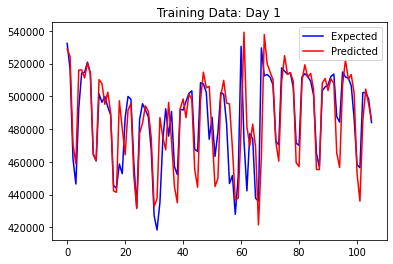

In [21]:
y_predict_test = TCN_funct.predict([X_ts_val, X_ft_val])
y1 = []
y2 = []
for i in range(0,y_predict_test.shape[0]):
  y1.append(y_predict_test[i][0])
  y2.append(y_val[i][0])
forcast = np.array(y1)
actual = np.array(y2)
actual = actual.flatten()
forcast = forcast*std + mean ## Return data into the intial range before normalization
actual = actual*std + mean

plt.plot(actual,color="blue", label="Expected")
plt.plot(forcast,color="red", label="Predicted")
plt.legend(loc="upper right")
plt.title("Training Data: Day 1")

print(forecast_accuracy(forcast, actual))

##**7th Day prediction evaluation**

4/4 [==============================] - 0s 4ms/step
{'mape': 0.036704384, 'me': 8438.071, 'mae': 17419.137, 'mpe': 0.018381616, 'rmse': 21814.218482448552, 'corr': 0.7055238685165967, 'minmax': 0.03512084484100342, 'mse': 475860130.0}


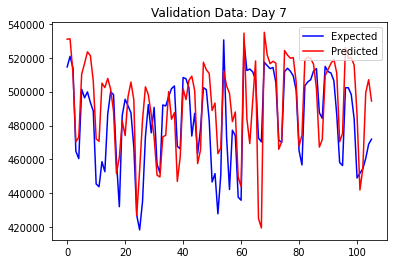

In [22]:
y_predict_test = TCN_funct.predict([X_ts_val, X_ft_val])
y1 = []
y2 = []
for i in range(0,y_predict_test.shape[0]):
  y1.append(y_predict_test[i][6])
  y2.append(y_val[i][6])
forcast = np.array(y1)
actual = np.array(y2)
actual = actual.flatten()
forcast = forcast*std + mean ## Return data into the intial range before normalization
actual = actual*std + mean

plt.plot(actual,color="blue", label="Expected")
plt.plot(forcast,color="red", label="Predicted")
plt.legend(loc="upper right")
plt.title("Validation Data: Day 7")

print(forecast_accuracy(forcast, actual))

##**Total Average prediction evaluation**

In [23]:
y_predict_test = TCN_funct.predict([X_ts_val, X_ft_val])
y1 = []
y2 = []
for i in range(0,y_predict_test.shape[0]):
  y1.append(y_predict_test[i].sum()/7)
  y2.append(y_val[i].sum()/7)
forcast = np.array(y1)
actual = np.array(y2)
actual = actual.flatten()
forcast = forcast*std + mean ## Return data into the intial range before normalization
actual = actual*std + mean

print(forecast_accuracy(forcast, actual))

4/4 [==============================] - 0s 4ms/step
{'mape': 0.01940899583989066, 'me': 2648.7206391123314, 'mae': 9333.362446094061, 'mpe': 0.005785927369996087, 'rmse': 12364.425611193998, 'corr': 0.6062176284049181, 'minmax': 0.018989656515529973, 'mse': 152879020.69475007}


#**LSTM Model**

In [24]:
n_inputs, n_channels, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
n_cells = 50
epochs =  300;
time_series = Input(shape=(n_inputs, 1))
other_feat = Input(shape=(n_inputs, n_channels-1))

conv1 = LSTM(n_cells, activation='linear', input_shape=(n_inputs,7), return_sequences=True)(time_series)
flat_ts = Flatten() (conv1)
flat_ft = Flatten() (other_feat)
merged = Concatenate(axis = 1) ([flat_ts, flat_ft])
dense_network = Dense(100, activation = 'linear')(merged)
dense_network = Dense(50, activation = 'linear')(dense_network)
dense_network = Dense(25, activation = 'linear')(dense_network)
output_ts = Dense(7, activation = 'linear') (dense_network)
LSTM_funct = Model(inputs = [time_series, other_feat], outputs = output_ts)
LSTM_funct.compile(optimizer = 'adam', loss = "mse")
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=100, verbose=2, mode='min')
LSTM_history = LSTM_funct.fit(x = [X_ts_train, X_ft_train], y = y_train, validation_data=[[X_ts_val,X_ft_val], y_val], epochs = epochs, batch_size = 10, callbacks=[monitor]) 


Epoch 1/300
43/43 [==============================] - 2s 12ms/step - loss: 0.4834 - val_loss: 0.1663
Epoch 2/300
43/43 [==============================] - 0s 8ms/step - loss: 0.2905 - val_loss: 0.1951
Epoch 3/300
43/43 [==============================] - 0s 6ms/step - loss: 0.2654 - val_loss: 0.1864
Epoch 4/300
43/43 [==============================] - 0s 11ms/step - loss: 0.2564 - val_loss: 0.1514
Epoch 5/300
43/43 [==============================] - 0s 11ms/step - loss: 0.2446 - val_loss: 0.1404
Epoch 6/300
43/43 [==============================] - 1s 18ms/step - loss: 0.2309 - val_loss: 0.1598
Epoch 7/300
43/43 [==============================] - 1s 16ms/step - loss: 0.2297 - val_loss: 0.1482
Epoch 8/300
43/43 [==============================] - 0s 7ms/step - loss: 0.2182 - val_loss: 0.1564
Epoch 9/300
43/43 [==============================] - 0s 7ms/step - loss: 0.2362 - val_loss: 0.1499
Epoch 10/300
43/43 [==============================] - 0s 7ms/step - loss: 0.2169 - val_loss: 0.1810
Epoc

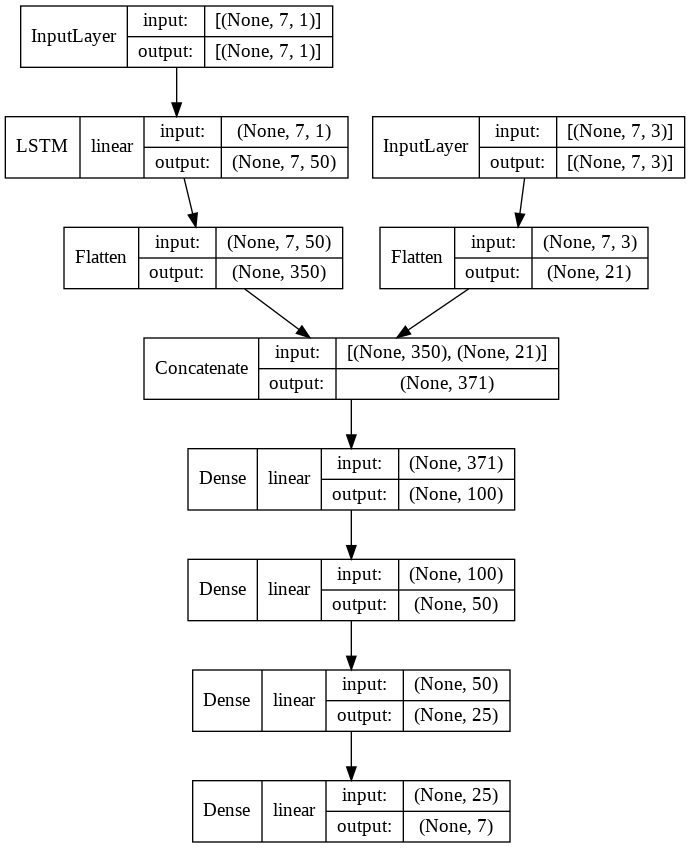

In [25]:
plot_model(LSTM_funct, to_file='functional LSTM model.png', show_shapes=True, show_dtype=False, show_layer_names=False, show_layer_activations=True)

##**LSTM Model evalution on training and validation set**

14/14 [==============================] - 0s 3ms/step


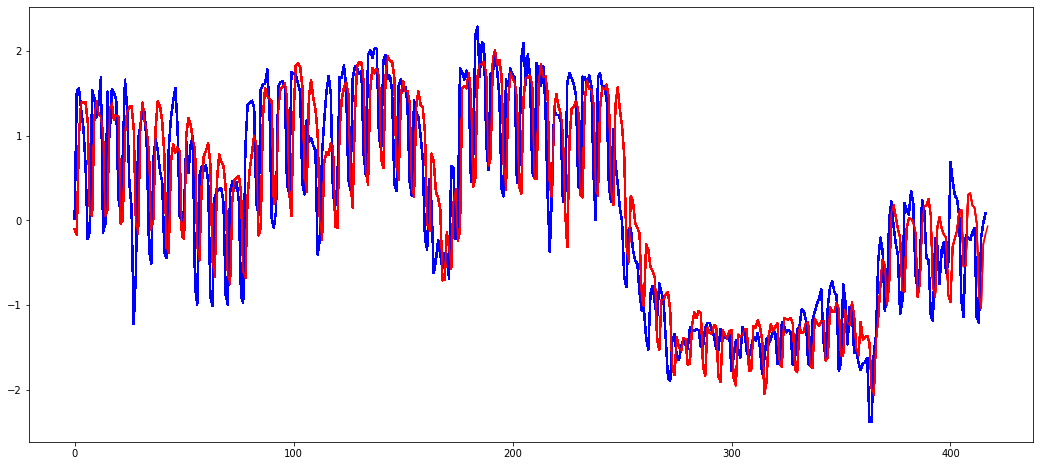

In [26]:
# cell that plots averaged predictions
y_predict_train= LSTM_funct.predict([X_ts_train, X_ft_train])
y_tren= y_train[7:-6,0,0]
plotted_days=y_train.shape[0]-6*2
y_pred=[]
for d in range(0,plotted_days):
  #y_pred= y_predict_train[:,d]
  prediction = 0
  for i in [0,1,2,3,4,5,6]:
    prediction = prediction + y_predict_train[d+i,6-i]
  prediction = prediction/7
  y_pred.append(prediction)
  plt.figure(num=1, figsize=[18,8])
  plt.plot(y_tren,color="blue")
  plt.plot(y_pred,color="red")

##**First Day prediction evaluation**

4/4 [==============================] - 0s 4ms/step
{'mape': 0.025488606, 'me': 1348.0248, 'mae': 12272.075, 'mpe': 0.0034628515, 'rmse': 17108.766407897445, 'corr': 0.7898117112611948, 'minmax': 0.0248262882232666, 'mse': 292709900.0}


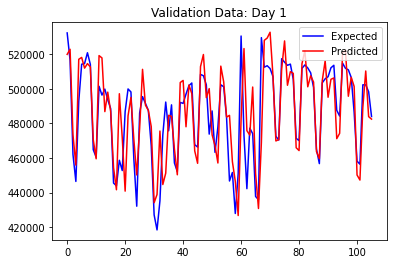

In [27]:
y_predict_test = LSTM_funct.predict([X_ts_val, X_ft_val])
y1 = []
y2 = []
for i in range(0,y_predict_test.shape[0]):
  y1.append(y_predict_test[i][0])
  y2.append(y_val[i][0])
forcast = np.array(y1)
actual = np.array(y2)
actual = actual.flatten()
forcast = forcast*std + mean ## Return data into the intial range before normalization
actual = actual*std + mean

plt.plot(actual,color="blue", label="Expected")
plt.plot(forcast,color="red", label="Predicted")
plt.legend(loc="upper right")
plt.title("Validation Data: Day 1")

print(forecast_accuracy(forcast, actual))

##**7th Day prediction evaluation**

4/4 [==============================] - 0s 4ms/step
{'mape': 0.038467042, 'me': 10296.653, 'mae': 18190.04, 'mpe': 0.022491978, 'rmse': 22775.006652029762, 'corr': 0.6762735042040536, 'minmax': 0.03653198480606079, 'mse': 518700930.0}


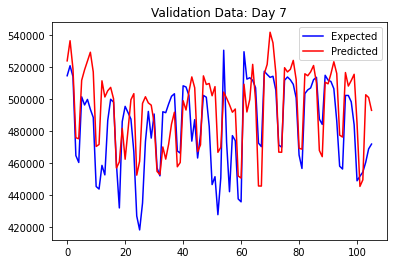

In [28]:
y_predict_test = LSTM_funct.predict([X_ts_val, X_ft_val])
y1 = []
y2 = []
for i in range(0,y_predict_test.shape[0]):
  y1.append(y_predict_test[i][6])
  y2.append(y_val[i][6])
forcast = np.array(y1)
actual = np.array(y2)
actual = actual.flatten()
forcast = forcast*std + mean ## Return data into the intial range before normalization
actual = actual*std + mean

plt.plot(actual,color="blue", label="Expected")
plt.plot(forcast,color="red", label="Predicted")
plt.legend(loc="upper right")
plt.title("Validation Data: Day 7")

print(forecast_accuracy(forcast, actual))

##**Total Average prediction evaluation**

In [29]:
y_predict_test = LSTM_funct.predict([X_ts_val, X_ft_val])
y1 = []
y2 = []
for i in range(0,y_predict_test.shape[0]):
  y1.append(y_predict_test[i].sum()/7)
  y2.append(y_val[i].sum()/7)
forcast = np.array(y1)
actual = np.array(y2)
actual = actual.flatten()
forcast = forcast*std + mean ## Return data into the intial range before normalization
actual = actual*std + mean

print(forecast_accuracy(forcast, actual))

4/4 [==============================] - 0s 6ms/step
{'mape': 0.023500454847609695, 'me': 4809.813536568503, 'mae': 11274.159711405011, 'mpe': 0.010305463242174196, 'rmse': 14577.562082688977, 'corr': 0.5142730247996523, 'minmax': 0.022888009384121832, 'mse': 212505316.27465138}


#**Comparing all Models using Test set**

In [30]:
X_ts_test = X_test[:,:,0]
X_ft_test = X_test[:,:,1:]
y_predict_test = TCN_funct.predict([X_ts_test, X_ft_test])
y1 = []
y2 = []
for i in range(0,y_predict_test.shape[0]):
  y1.append(y_predict_test[i].sum()/7)
  y2.append(y_test[i].sum()/7)

forcast = np.array(y1)
actual = np.array(y2)
actual = actual.flatten()
forcast = forcast*std + mean
actual = actual*std + mean


print(forecast_accuracy(forcast, actual))

6/6 [==============================] - 0s 3ms/step
{'mape': 0.029916316443320125, 'me': -7076.787307811046, 'mae': 14865.826658687854, 'mpe': -0.013536869814930191, 'rmse': 18674.625922807427, 'corr': 0.6722921494660514, 'minmax': 0.029519882492776373, 'mse': 348741653.35679114}


In [31]:
y_predict_test = LSTM_funct.predict([X_ts_test, X_ft_test])
y1 = []
y2 = []
for i in range(0,y_predict_test.shape[0]):
  y1.append(y_predict_test[i].sum()/7)
  y2.append(y_test[i].sum()/7)

forcast = np.array(y1)
actual = np.array(y2)
actual = actual.flatten()
forcast = forcast*std + mean
actual = actual*std + mean

print(forecast_accuracy(forcast, actual))

6/6 [==============================] - 0s 3ms/step
{'mape': 0.02746910057052471, 'me': -288.22553590715444, 'mae': 13516.35616631004, 'mpe': 0.00021155103905919103, 'rmse': 18328.387723403215, 'corr': 0.6548455227226574, 'minmax': 0.02673355048204773, 'mse': 335929796.53939766}
